In [4]:
import os
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
import math
import numpy as np
import numpy.ma as ma
from scipy.ndimage import convolve

# Global constants
R_ARENA_SIZE = 2 * 1.231  # Arena size
R_DT = 0.1                # Time step

def read_best_fsms(file_path='best_fsms.csv'):
    """Reads the best FSMs from a CSV file."""
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} does not exist.")
        return None
    return pd.read_csv(file_path, index_col=0)

def find_fsm_number(fsm, autocontrollers_path):
    """Finds the FSM number in the autocontrollers file."""
    with open(autocontrollers_path, 'r') as f:
        for i, line in enumerate(f):
            if fsm in line:
                return i
    return None

def read_performance_data(mission, fsm_number):
    """Reads performance data for a given mission and FSM number."""
    base_path = f'argoslogs_chocosim/{mission}/Chocolate/simulation/{fsm_number}'
    all_data = []
    
    for filename in os.listdir(base_path):
        if filename.endswith('.csv'):
            with open(os.path.join(base_path, filename), 'r') as f:
                lines = f.readlines()
                
                # Extract positions
                positions_end = next((i for i, line in enumerate(lines) if line.strip() == "# SDBC"), len(lines))
                positions = []
                for line in lines[1:positions_end]:
                    try:
                        pos = [float(x) for x in line.strip().split(',') if x]
                        if pos:
                            positions.append(pos)
                    except ValueError:
                        continue
                
                # Extract objective function
                try:
                    objective_function = float(lines[-1].strip())
                except ValueError:
                    print(f"Warning: Invalid objective function in file {filename}")
                    continue
                
                if positions and objective_function is not None:
                    positions = np.array(positions)
                    x = positions[:, ::2]
                    y = positions[:, 1::2]
                    vx = (x[:, 1:] - x[:, :-1]) / R_DT
                    vy = (y[:, 1:] - y[:, :-1]) / R_DT
                    
                    all_data.append({
                        'x': x, 'y': y, 'vx': vx, 'vy': vy,
                        'objective_function': objective_function,
                        'num_robots': len(positions)
                    })
    
    if not all_data:
        print(f"Warning: No valid data found for mission {mission}, FSM number {fsm_number}")
        return None, None, None
    
    avg_objective_function = np.mean([data['objective_function'] for data in all_data])
    avg_num_robots = np.mean([data['num_robots'] for data in all_data])
    
    return avg_objective_function, avg_num_robots, all_data

def compute_vector_field(run_data, w):
    """
    Computes the mesoscopic vector field U for a single run.
    U_i = (1/M_i) ∑_{k=1}^K ∑_{n=1}^{m_i^k} u_n^k for i ∈ Ω,
    where u_n^k = (x_n^{k+1} - x_n^k)/Δt
    """
    # Transform coordinates to image space
    x_image = -run_data['y'] + R_ARENA_SIZE / 2
    y_image = -run_data['x'] + R_ARENA_SIZE / 2
    vx_image = -run_data['vy']  # Inverted velocities
    vy_image = -run_data['vx']
    
    # Compute grid dimensions
    nx_bins = int(2 * np.ceil(0.5 * R_ARENA_SIZE / w))
    ny_bins = nx_bins
    
    # Create grid edges ensuring coverage of arena
    x_diff = nx_bins * w - R_ARENA_SIZE
    y_diff = ny_bins * w - R_ARENA_SIZE
    x_bins = np.linspace(-x_diff / 2, R_ARENA_SIZE + x_diff / 2, nx_bins + 1)
    y_bins = np.linspace(-y_diff / 2, R_ARENA_SIZE + y_diff / 2, ny_bins + 1)
    
    # Discretize positions
    xd = np.digitize(x_image, x_bins) - 1
    yd = np.digitize(y_image, y_bins) - 1
    
    # Initialize occupancy counter M and velocity accumulator V_sum
    M = np.zeros((ny_bins, nx_bins), dtype=np.int32)
    V_sum = np.zeros((ny_bins, nx_bins, 2), dtype=np.float64)
    
    # Compute M and accumulate velocities
    for t in range(vx_image.shape[1]):
        valid = (yd[:, t] >= 0) & (yd[:, t] < ny_bins) & \
                (xd[:, t] >= 0) & (xd[:, t] < nx_bins)
        if np.any(valid):
            y_idx = yd[valid, t]
            x_idx = xd[valid, t]
            np.add.at(M, (y_idx, x_idx), 1)
            np.add.at(V_sum, (y_idx, x_idx, 0), vx_image[valid, t])
            np.add.at(V_sum, (y_idx, x_idx, 1), vy_image[valid, t])
    
    # Compute U_i = (1/M_i) * V_sum for occupied cells
    mask = M > 0
    U = np.zeros((ny_bins, nx_bins, 2), dtype=np.float64)
    with np.errstate(divide='ignore', invalid='ignore'):
        U[mask, 0] = V_sum[mask, 0] / M[mask]
        U[mask, 1] = V_sum[mask, 1] / M[mask]
    
    # Mask unoccupied cells
    U = ma.masked_array(U, mask=np.broadcast_to(~mask[..., None], U.shape))
    return U, mask

def compute_roughness(U, w):
    """
    Computes the roughness R(U) = R(U_x) + R(U_y),
    where R(U_α) = ∫_Ω ||H U_α||_F^2 dx for α ∈ {x, y}
    """
    def hessian(f):
        # Compute second derivatives with correct axes
        f_xx = np.gradient(np.gradient(f, w, axis=1, edge_order=2), w, axis=1, edge_order=2)
        f_yy = np.gradient(np.gradient(f, w, axis=0, edge_order=2), w, axis=0, edge_order=2)
        f_xy = np.gradient(np.gradient(f, w, axis=1, edge_order=2), w, axis=0, edge_order=2)
        f_yx = np.gradient(np.gradient(f, w, axis=0, edge_order=2), w, axis=1, edge_order=2)
        # Average mixed derivatives for symmetry
        f_xy_avg = (f_xy + f_yx) / 2.0
        return np.array([[f_xx, f_xy_avg],
                         [f_xy_avg, f_yy]])
    
    # Compute Hessian matrices for U_x and U_y
    Hx = hessian(U[:, :, 0])
    Hy = hessian(U[:, :, 1])
    
    # Compute squared Frobenius norms
    norm_Hx_squared = Hx[0, 0, :, :]**2 + 2 * Hx[0, 1, :, :]**2 + Hx[1, 1, :, :]**2
    norm_Hy_squared = Hy[0, 0, :, :]**2 + 2 * Hy[0, 1, :, :]**2 + Hy[1, 1, :, :]**2
    
    # Integrate over Ω using the trapezoidal rule along both axes
    R_Ux = np.trapezoid(np.trapezoid(norm_Hx_squared, dx=w, axis=1), dx=w, axis=0)
    R_Uy = np.trapezoid(np.trapezoid(norm_Hy_squared, dx=w, axis=1), dx=w, axis=0)
    
    return (R_Ux + R_Uy)* w**2 

def compute_connections(mask):
    """
    Computes N_c(U(w)): number of connections between occupied cells
    using 8-neighbourhood connectivity
    """
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    neighbor_counts = convolve(mask.astype(int), kernel, mode='constant', cval=0)
    total_connections = (neighbor_counts * mask).sum()
    return total_connections // 2  # Each connection is counted twice

def process_single_run(args):
    """
    Process a single run to compute the quality score:
    score = N_c(U(w)) / Adjusted R(U(w))
    """
    run_data, w = args
    U, mask = compute_vector_field(run_data, w)
    R = compute_roughness(U, w)  # R is already adjusted
    N_c = compute_connections(mask)
    
    if R > 1e-8:  # Threshold to avoid division by very small roughness values
        quality_score = N_c / R
    else:
        quality_score = 0
    
    return quality_score, N_c, R

def find_optimal_bin_width(all_mission_data, n_workers=None):
    """Find the optimal bin width using parallel processing with scaling adjustment."""
    if n_workers is None:
        n_workers = min(mp.cpu_count() - 1, 25)
    
    w_range = np.linspace(0.14, 0.24, 15)  # Adjust as needed
    metrics = {}
    
    quality_scores = []
    N_c_values = []
    R_values = []
    
    with mp.Pool(processes=n_workers) as pool:
        for w in tqdm(w_range, desc="Processing bin widths"):
            # Prepare all run data for this w
            run_params = [(run_data, w) for mission_data in all_mission_data 
                          for run_data in mission_data]
            
            # Process all runs for this w in parallel
            results = pool.map(process_single_run, run_params)
            
            # Unpack results
            quality_scores_w, N_c_w, R_w = zip(*results)
            
            # Check if all results have zero quality scores
            if all(score == 0 for score in quality_scores_w):
                print(f"\nAll roughness values below threshold at w = {w:.4f}. Stopping computation.")
                break
            
            metrics[w] = results
            quality_scores.append(np.median(quality_scores_w))
            N_c_values.append(np.median(N_c_w))
            R_values.append(np.median(R_w))
        
    # Use only the w values that were actually computed
    computed_w = list(metrics.keys())
    
    if not computed_w:
        print("No valid results found. All roughness values below threshold.")
        return None, None, None, None, None, None
    
    # Find optimal w based on the adjusted quality scores
    optimal_w = computed_w[np.argmax(quality_scores)]
    
    return optimal_w, computed_w, N_c_values, R_values, quality_scores


In [5]:
# Load best FSMs
best_fsms = read_best_fsms()
if best_fsms is None:
    exit(1)

# Collect all mission data
all_mission_data = []
for mission, row in best_fsms.iterrows():
    mission_name = mission.split('_')[0]
    best_fsm = row['Best FSM']
    autocontrollers_path = f'Design/{mission_name}/Chocolate/autocontrollers.txt'
    
    fsm_number = find_fsm_number(best_fsm, autocontrollers_path)
    if fsm_number is not None:
        _, _, mission_data = read_performance_data(mission_name, fsm_number)
        if mission_data is not None:
            all_mission_data.append(mission_data)
        else:
            print(f"No valid data found for {mission_name}")
    else:
        print(f"Could not find FSM number for {mission_name}")

In [6]:
# Find optimal bin width
optimal_w_normalized, computed_w, N_c_values, R_values, quality_scores_normalized = find_optimal_bin_width(all_mission_data)
print(f"Optimal bin width (Normalized): {optimal_w_normalized:.4f} m")

# Display results for each mission
for mission, data in zip(best_fsms.index, all_mission_data):
    avg_performance = np.mean([run['objective_function'] for run in data])
    avg_num_robots = np.mean([run['num_robots'] for run in data])
    print(f"\nMission: {mission}")
    print(f"Average Performance: {avg_performance:.4f}")
    print(f"Average Number of Robots: {avg_num_robots:.2f}")

Processing bin widths: 100%|██████████| 15/15 [10:43<00:00, 42.92s/it]

Optimal bin width (Normalized): 0.2043 m

Mission: DirectionalGate_Chocolate_simulation
Average Performance: 445.5650
Average Number of Robots: 20.00

Mission: Foraging_Chocolate_simulation
Average Performance: 486.2900
Average Number of Robots: 20.00

Mission: Homing_Chocolate_simulation
Average Performance: 0.9897
Average Number of Robots: 20.00

Mission: Shelter_Chocolate_simulation
Average Performance: 169660.8600
Average Number of Robots: 20.00

Mission: XOR-Aggregation_Chocolate_simulation
Average Performance: 244984.4400
Average Number of Robots: 20.00


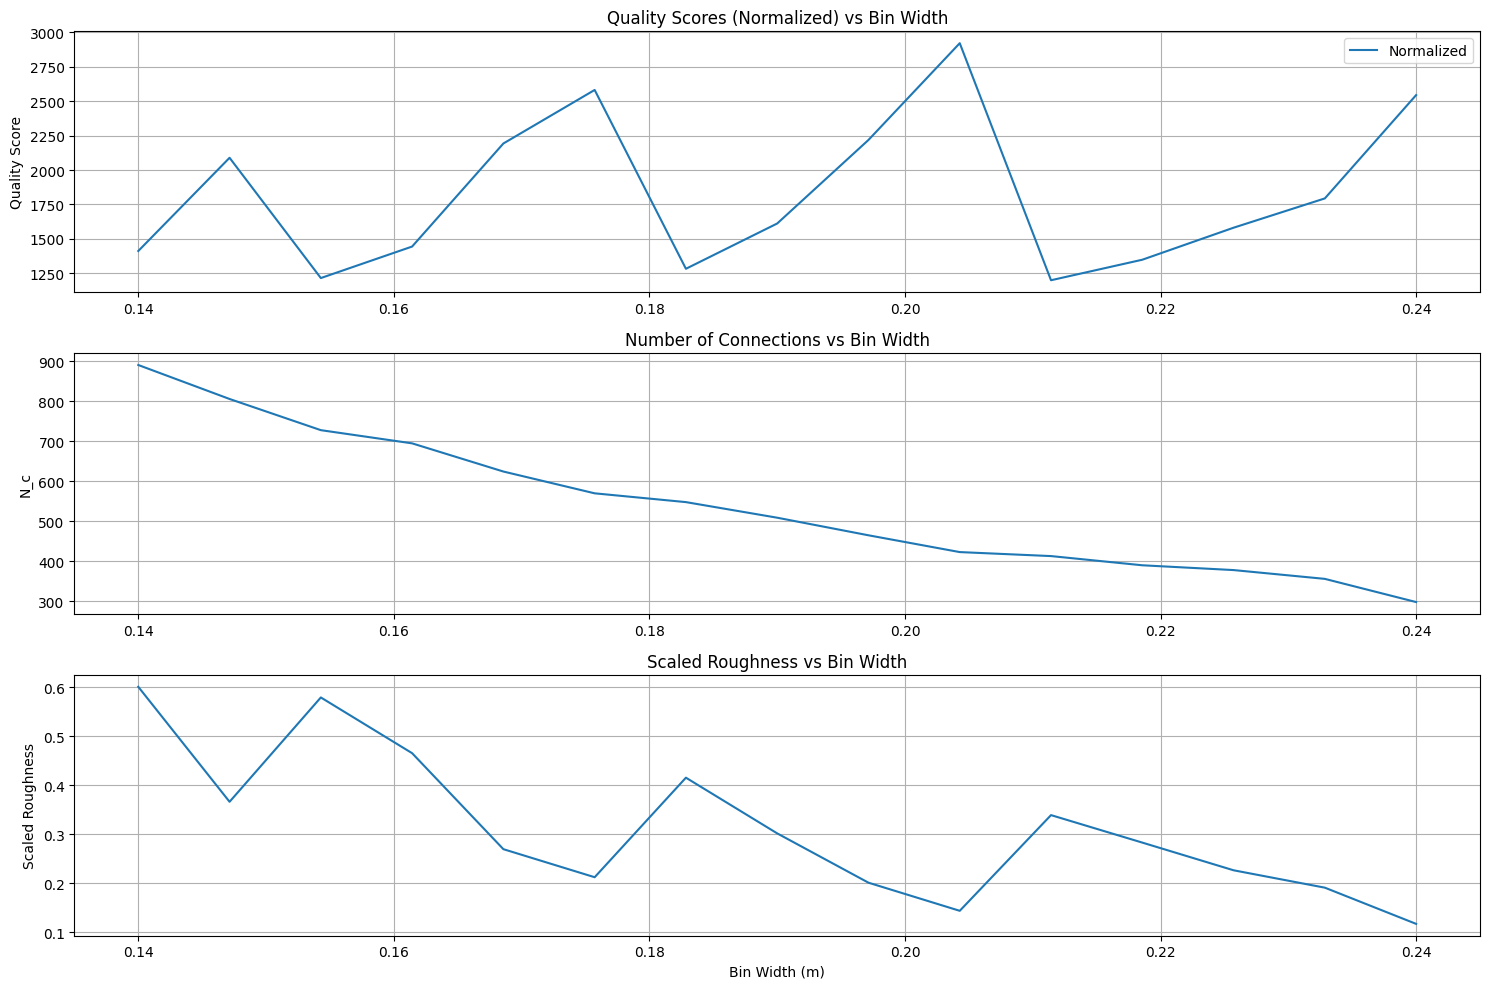

In [7]:
# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(311)
plt.plot(computed_w, quality_scores_normalized, label='Normalized')
plt.ylabel('Quality Score')
plt.title('Quality Scores (Normalized) vs Bin Width')
plt.legend()
plt.grid(True)

plt.subplot(312)
plt.plot(computed_w, N_c_values)
plt.ylabel('N_c')
plt.title('Number of Connections vs Bin Width')
plt.grid(True)

plt.subplot(313)
plt.plot(computed_w, R_values)
plt.xlabel('Bin Width (m)')
plt.ylabel('Scaled Roughness')
plt.title('Scaled Roughness vs Bin Width')
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
import os
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import multiprocessing as mp
from scipy.ndimage import convolve

# Global variables (unchanged)
R_ARENA_SIZE = 2 * 1.231
R_EPUCK_RADIUS = 0.035
R_DT = 0.1 
optimal_w_normalized = 0.2043  # Previously computed optimal bin widths

def read_best_fsms(file_path='best_fsms.csv'):
    return pd.read_csv(file_path, index_col=0)

best_fsms = read_best_fsms()

import joblib

# Define file paths
all_mission_data_path = 'all_mission_data.joblib'
mission_vector_fields_path = 'mission_vector_fields.joblib'

# Load all_mission_data
all_mission_data = joblib.load(all_mission_data_path)
print(f"Loaded all_mission_data from {all_mission_data_path}")


Loaded all_mission_data from all_mission_data.joblib


Generating mission vector fields:   0%|          | 0/5 [00:00<?, ?it/s]


Mission: DirectionalGate_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 132
Mean velocity magnitude: 0.0525

Mission: Foraging_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 127
Mean velocity magnitude: 0.0349

Mission: Homing_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 125
Mean velocity magnitude: 0.0339

Mission: Shelter_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 124
Mean velocity magnitude: 0.0399

Mission: XOR-Aggregation_Chocolate_simulation
Vector field shape: (14, 14, 2)
Number of occupied cells: 126
Mean velocity magnitude: 0.0121


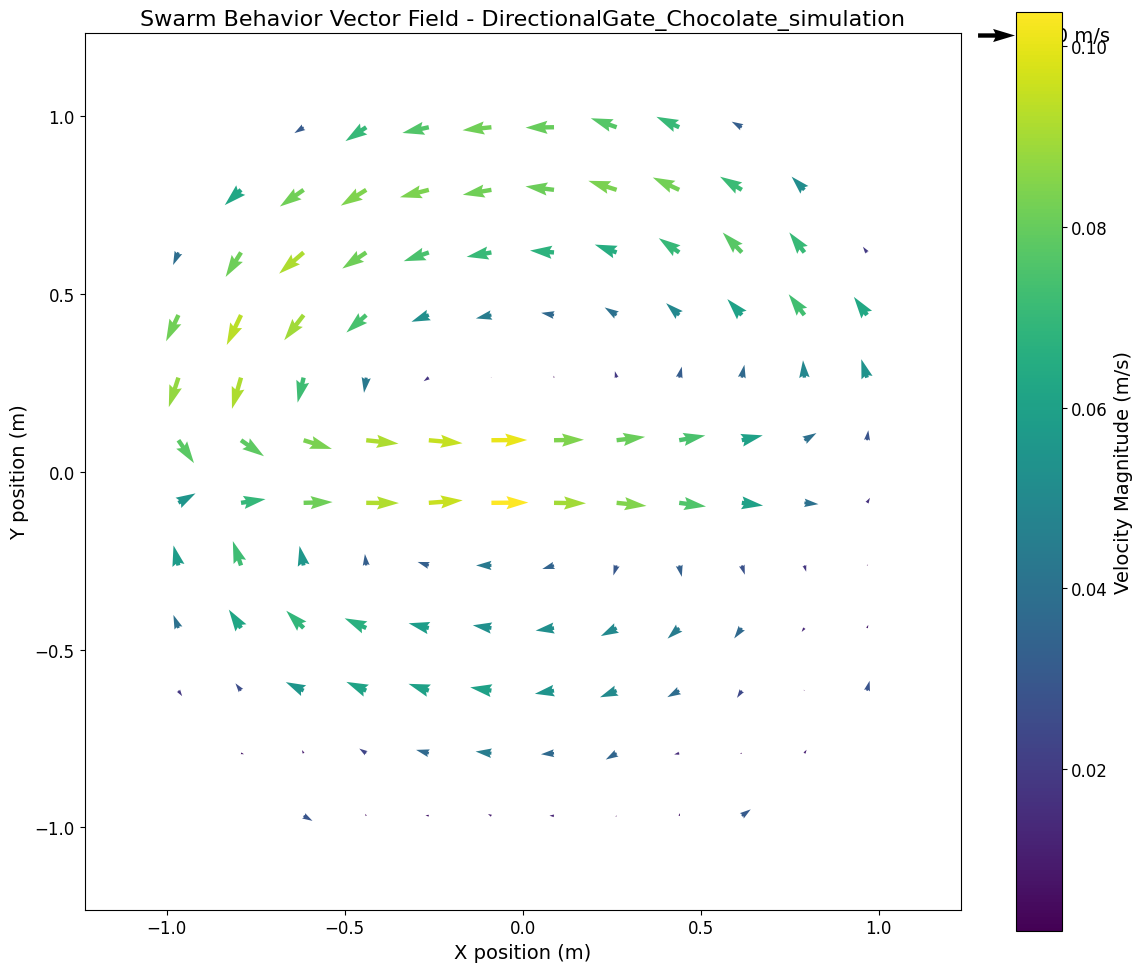

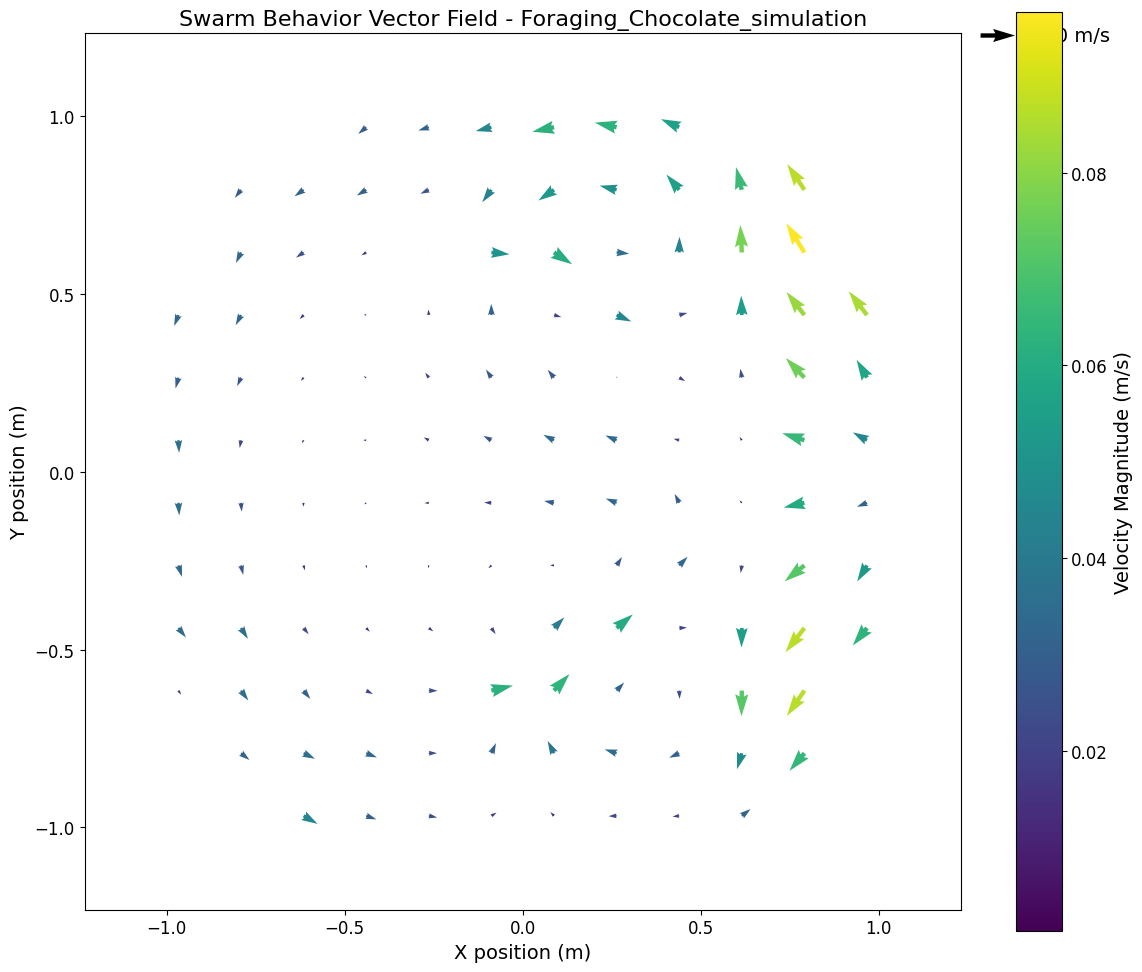

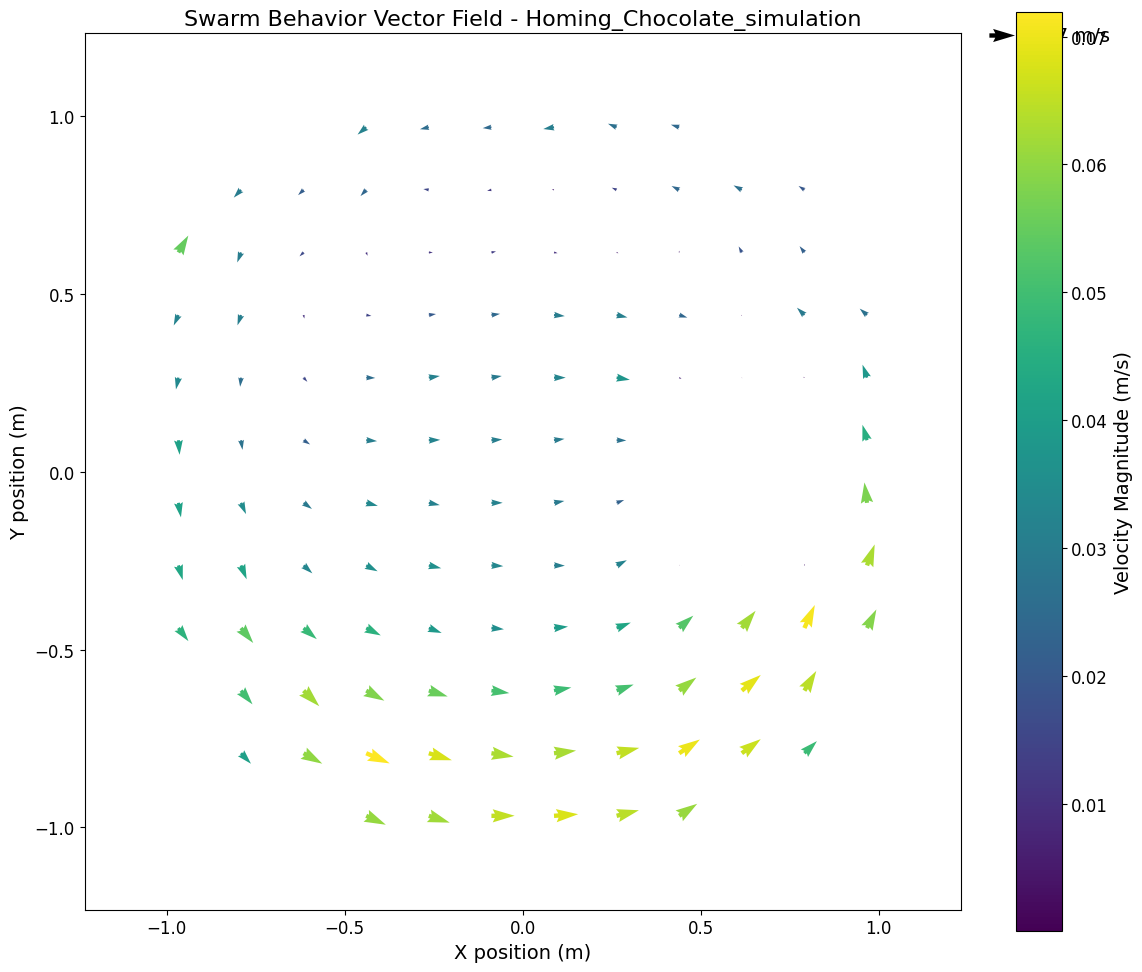

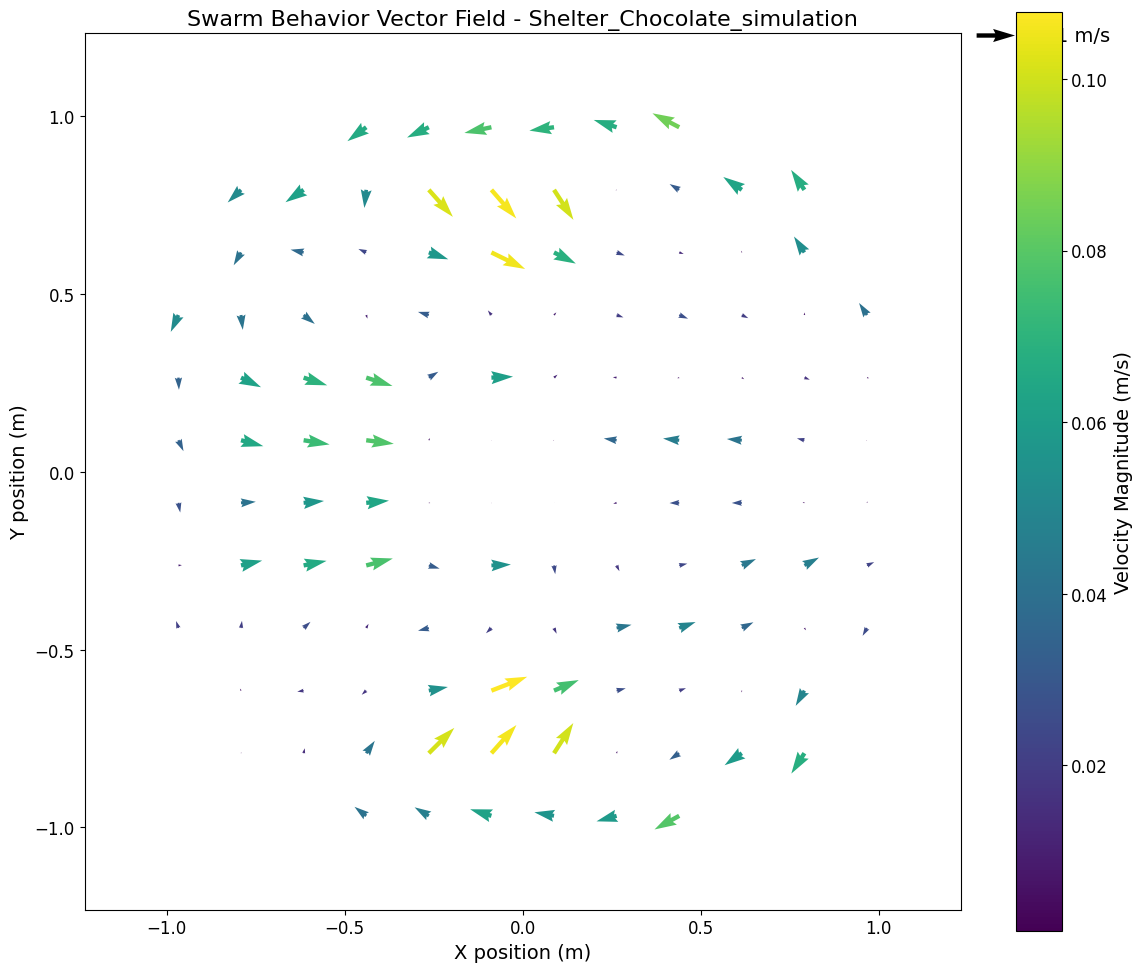

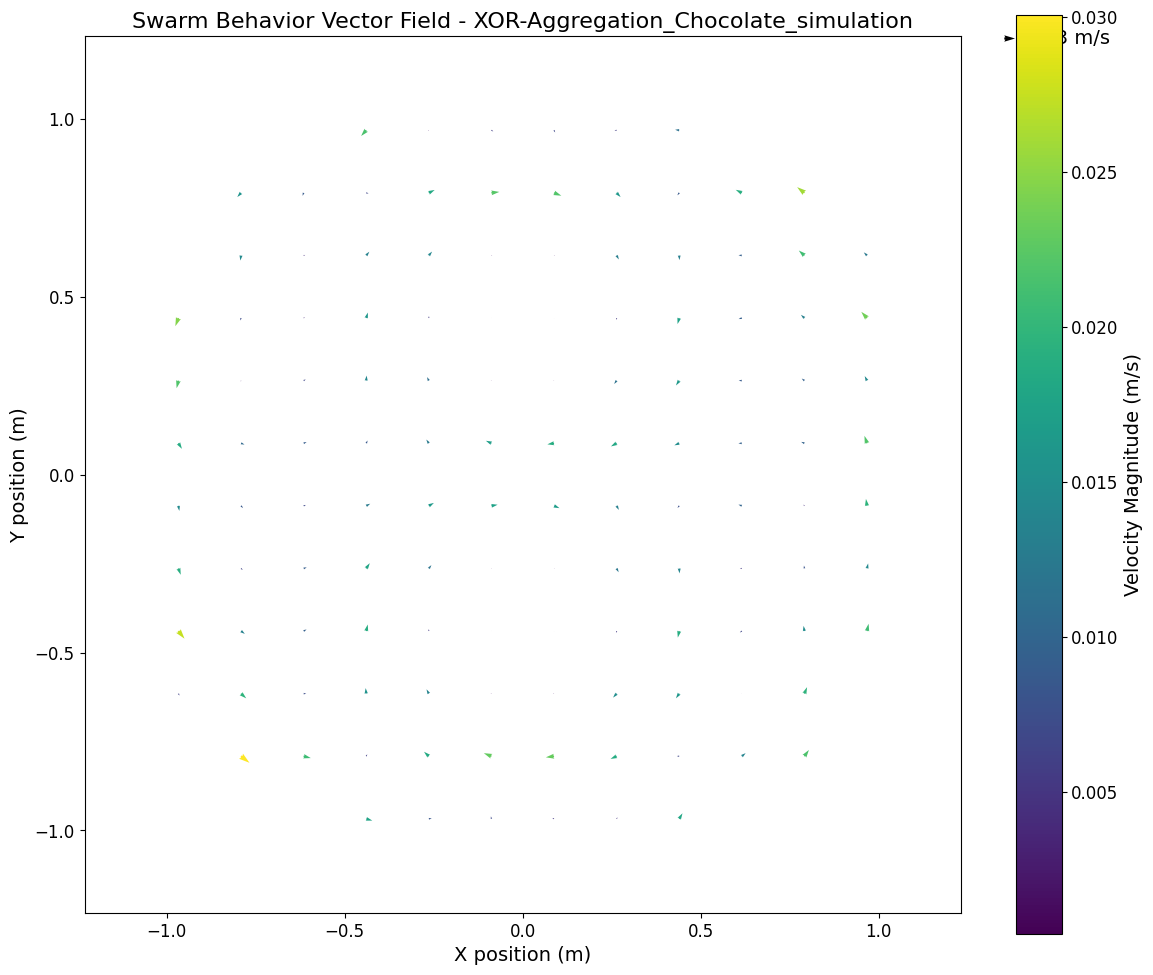

In [12]:
def generate_vector_field(x, y, vx, vy, w):
    """Generates the vector field U using the correct methodology"""
    # Transform coordinates
    x_image = -y + R_ARENA_SIZE/2
    y_image = -x + R_ARENA_SIZE/2
    vx_image = -vy
    vy_image = -vx
    
    # Compute grid dimensions
    nx_bins = int(2 * np.ceil(0.5 * R_ARENA_SIZE / w))
    ny_bins = nx_bins
    
    # Create grid edges
    x_diff = nx_bins * w - R_ARENA_SIZE
    y_diff = ny_bins * w - R_ARENA_SIZE
    x_bins = np.linspace(-x_diff/2, R_ARENA_SIZE + x_diff/2, nx_bins + 1)
    y_bins = np.linspace(-y_diff/2, R_ARENA_SIZE + y_diff/2, ny_bins + 1)
    
    # Discretize positions
    xd = np.digitize(x_image, x_bins) - 1
    yd = np.digitize(y_image, y_bins) - 1
    
    # Initialize accumulation arrays
    M = np.zeros((ny_bins, nx_bins), dtype=np.int32)
    V_sum = np.zeros((ny_bins, nx_bins, 2), dtype=np.float64)
    
    # Compute M_i and velocity sums
    for t in range(vx_image.shape[1]):
        valid = (yd[:, t] >= 0) & (yd[:, t] < ny_bins) & \
                (xd[:, t] >= 0) & (xd[:, t] < nx_bins)
        
        if np.any(valid):
            y_idx = yd[valid, t].astype(int)
            x_idx = xd[valid, t].astype(int)
            
            np.add.at(M, (y_idx, x_idx), 1)
            np.add.at(V_sum, (y_idx, x_idx, 0), vx_image[valid, t])
            np.add.at(V_sum, (y_idx, x_idx, 1), vy_image[valid, t])
    
    # Compute vector field
    mask = M > 0
    U = np.zeros((ny_bins, nx_bins, 2), dtype=np.float64)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        U[mask, 0] = V_sum[mask, 0] / M[mask]
        U[mask, 1] = V_sum[mask, 1] / M[mask]
    
    U = ma.masked_array(U, mask=np.broadcast_to(~mask[..., None], U.shape))
    return U, mask

def generate_mission_vector_field(mission_data, optimal_w):
    """Generates a vector field for all runs in a mission"""
    all_x = np.concatenate([run['x'] for run in mission_data])
    all_y = np.concatenate([run['y'] for run in mission_data])
    all_vx = np.concatenate([run['vx'] for run in mission_data])
    all_vy = np.concatenate([run['vy'] for run in mission_data])
    
    U, mask = generate_vector_field(all_x, all_y, all_vx, all_vy, optimal_w)
    return U, mask

def visualize_vector_field(mission_name, U, mask, R_ARENA_SIZE):
    """Visualizes the vector field for a given mission."""
    ny_bins, nx_bins = U.shape[:2]
    
    # Create grid
    x_edges = np.linspace(-R_ARENA_SIZE / 2, R_ARENA_SIZE / 2, nx_bins + 1)
    y_edges = np.linspace(-R_ARENA_SIZE / 2, R_ARENA_SIZE / 2, ny_bins + 1)
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    
    # Prepare masked arrays
    Ux = np.ma.masked_array(U[:, :, 0], mask=~mask)
    Uy = np.ma.masked_array(U[:, :, 1], mask=~mask)
    speed = np.sqrt(Ux**2 + Uy**2)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    Q = plt.quiver(X, Y, Ux, Uy, speed, angles='xy', scale_units='xy', scale=1,
                  cmap='viridis', width=0.005, minlength=0)
    
    plt.title(f'Swarm Behavior Vector Field - {mission_name}', fontsize=16)
    plt.xlabel('X position (m)', fontsize=14)
    plt.ylabel('Y position (m)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(-R_ARENA_SIZE / 2, R_ARENA_SIZE / 2)
    plt.ylim(-R_ARENA_SIZE / 2, R_ARENA_SIZE / 2)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Add colorbar
    cbar = plt.colorbar(Q)
    cbar.set_label('Velocity Magnitude (m/s)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    # Add reference arrow
    max_speed = speed.max()
    plt.quiverkey(Q, 0.85, 0.95, max_speed, f'{max_speed:.2f} m/s',
                  labelpos='E', coordinates='figure', fontproperties={'size': 14})
    
    plt.tight_layout()
    plt.savefig(f'swarm_field_{mission_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# For Jupyter notebook usage:
def analyze_missions(best_fsms, all_mission_data, optimal_w_normalized):
    """Analyze all missions and generate vector fields"""
    # Generate vector fields for each mission
    mission_vector_fields = {}
    for mission, data in tqdm(zip(best_fsms.index, all_mission_data), 
                            total=len(best_fsms), 
                            desc="Generating mission vector fields"):
        U, mask = generate_mission_vector_field(data, optimal_w_normalized)
        mission_vector_fields[mission] = (U, mask)
    
    # Display basic information about the vector fields
    for mission, (U, mask) in mission_vector_fields.items():
        print(f"\nMission: {mission}")
        print(f"Vector field shape: {U.shape}")
        print(f"Number of occupied cells: {np.sum(mask)}")
        print(f"Mean velocity magnitude: {np.mean(np.linalg.norm(U, axis=2)[mask]):.4f}")
    
    # Visualize each vector field
    for mission, (U, mask) in mission_vector_fields.items():
        visualize_vector_field(mission, U, mask, R_ARENA_SIZE)
    
    return mission_vector_fields

# First cell: Import and data loading
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  

# Generate and visualize vector fields
mission_vector_fields = analyze_missions(best_fsms, all_mission_data, optimal_w_normalized)

In [20]:
#!/usr/bin/env python3

import os
import sys
import warnings
import re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import skfda as sf
from skfda.exploratory.stats import fisher_rao_karcher_mean
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda.misc.operators import SRSF
from functools import partial
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from time import time
from scipy.ndimage import convolve
from gudhi import AlphaComplex, SimplexTree
from gudhi.representations import Silhouette
from pynhhd import nHHD

# ----------------------------
# Monkey Patch for Deprecated np.float
# ----------------------------
import pynhhd.poisson
import pynhhd.nHHD

# Replace np.float with float globally within pynhhd.poisson
pynhhd.poisson.np.float = float  # or np.float64

In [ ]:
# Compute persistence diagrams and align silhouettes using the Fisher-Rao metric

def createSimplexTree(x, mask=None):
    """Encode masked 2D array as simplex tree."""
    # Ensure the input is a masked array
    if mask is not None:
        if not ma.isMaskedArray(x):
            x = ma.masked_where(~mask, x)
        else:
            x = ma.masked_where(~mask, x)
    else:
        if not ma.isMaskedArray(x):
            x = ma.masked_array(x, mask=x == 0)
        else:
            x = ma.masked_where(x == 0, x)

    m = x.mask
    if isinstance(m, np.bool_):
        m = np.full(x.shape, m)

    r, c = np.nonzero(~m)
    points = []
    filtration_values = []
    for ri, ci in zip(r, c):
        points.append([ci, -ri])  # Note the swapping of axes to match the coordinate system
        filtration_values.append(float(x[ri, ci]))

    # Define the number of bins based on component shape
    nx_bins, ny_bins = m.shape
    points = np.array(points)
    #sclaing the points to fit the unit square

    ax = AlphaComplex(points=points)
    st = ax.create_simplex_tree(optimal_w_normalized*5)
    st.reset_filtration(-1e8)

    # Assign filtration values to vertices
    for idx, filtration in enumerate(filtration_values):
        st.assign_filtration([idx], filtration)
    st.make_filtration_non_decreasing()

    return st


def extendedPersistence(field, dx, mask):
    """Extended persistence for a masked vector field with separation dx."""
    def _pd2ndarr(dgm, dim):
        """Extracts PD of dimension dim from dgm into ndarray."""
        x = np.copy(np.atleast_2d(np.asarray([p[1] for p in dgm if p[0] == dim])))
        if x.size == 0:
            x = np.array([[0., 0.]])
        return x

    # Decompose field  into Divergence and Curl 
    ny_bins, nx_bins = field.shape[:2]
    nhhd = nHHD(grid=(ny_bins, nx_bins), spacings=dx)

    # Create the masked array directly from the field
    masked_field = ma.array(field, mask=np.dstack((mask, mask)))
    nhhd.decompose(masked_field)

    # Extended persistence pairs of natural potentials
    dgms = []
    for x in [nhhd.nD, -nhhd.nRu]:
        x_masked = ma.array(x, mask=mask)
        st = createSimplexTree(x_masked)
        st.extend_filtration()
        x_dgms = st.extended_persistence()

        dgms.extend([
            _pd2ndarr(x_dgms[0], 0),  # Ord H0
            _pd2ndarr(x_dgms[0], 1),  # Ord H1
            np.roll(_pd2ndarr(x_dgms[1], 1), 1, axis=1),  # Rel H1
            np.roll(_pd2ndarr(x_dgms[1], 2), 1, axis=1),  # Rel H2
            _pd2ndarr(x_dgms[2], 0),  # Ext+ H0
            np.roll(_pd2ndarr(x_dgms[3], 1), 1, axis=1)   # Ext- H1
        ])

    return dgms


def plot_silhouettes(silhouettes, titles=None):
    """Plot a list of silhouettes."""
    num_silhouettes = len(silhouettes)
    fig, axes = plt.subplots(2, (num_silhouettes + 1) // 2, figsize=(15, 6))
    axes = axes.flatten()
    for idx, sil in enumerate(silhouettes):
        axes[idx].plot(sil)
        if titles:
            axes[idx].set_title(titles[idx])
        axes[idx].set_xlabel('Normalized Persistence')
        axes[idx].set_ylabel('Silhouette Value')
    plt.tight_layout()
    plt.show()

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from typing import Tuple, List, Optional, Dict
import skfda
from skfda import FDataGrid, FDataBasis
from skfda.representation.basis import Fourier
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda.representation.grid import FDataGrid
from gudhi.representations import Silhouette
from skfda.preprocessing.registration import ElasticRegistration  # Import ElasticRegistration


def to_srvf(f: np.ndarray, t: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert function to Square Root Velocity Function (SRVF) representation.
    """
    if t is None:
        t = np.linspace(0, 1, len(f))
    df = np.gradient(f, t)
    # Handle zero derivatives to avoid sqrt(0)
    df[df == 0] = 1e-10
    q = np.sign(df) * np.sqrt(np.abs(df))
    return q, t

def from_srvf(q: np.ndarray, t: np.ndarray, f0: float = 0) -> np.ndarray:
    """
    Convert from SRVF back to original function space.
    """
    df = q * np.abs(q)
    f = f0 + cumulative_trapezoid(df, t, initial=0)
    return f

def elastic_distance(f1, f2, num_points=1000):
    """
    Compute elastic distance between two functions using SRVF framework.
    
    Args:
        f1, f2: Functions to compare (numpy arrays or FData objects)
        num_points: Number of points for interpolation
    
    Returns:
        float: Elastic distance between the functions
    """
    # Create uniform grid
    grid_points = np.linspace(0, 1, num_points)
    
    # Convert numpy arrays to FDataGrid if necessary
    if isinstance(f1, np.ndarray):
        f1 = FDataGrid(
            data_matrix=f1.reshape(1, -1),
            grid_points=np.linspace(0, 1, len(f1))
        )
    if isinstance(f2, np.ndarray):
        f2 = FDataGrid(
            data_matrix=f2.reshape(1, -1),
            grid_points=np.linspace(0, 1, len(f2))
        )
    
    # Evaluate on common grid if the input is FDataBasis
    if isinstance(f1, FDataBasis):
        f1 = f1.to_grid(grid_points)
    if isinstance(f2, FDataBasis):
        f2 = f2.to_grid(grid_points)
        
    # Ensure both functions are evaluated on the same grid
    if isinstance(f1, FDataGrid):
        f1 = f1(grid_points)
    if isinstance(f2, FDataGrid):
        f2 = f2(grid_points)
    
    f1 = f1.squeeze()
    f2 = f2.squeeze()
    
    # Convert to SRVF
    q1, _ = to_srvf(f1, grid_points)
    q2, _ = to_srvf(f2, grid_points)
    
    # Compute elastic distance (L2 norm in SRVF space)
    distance = np.sqrt(np.trapezoid((q1 - q2) ** 2, grid_points))
    
    return distance

def align_silhouettes(silhouettes: List[np.ndarray]) -> np.ndarray:
    """
    Align silhouettes using SRVF framework and elastic distance.
    
    Args:
        silhouettes: List of silhouettes to align (each as a 1D numpy array)
    
    Returns:
        Aligned silhouettes as a numpy array of the same shape as input
    """
    num_silhouettes = len(silhouettes)
    if num_silhouettes == 0:
        return np.array([])
    
    # Ensure all silhouettes are numpy arrays
    silhouettes = [np.asarray(sil).squeeze() for sil in silhouettes]
    
    # Get common length
    common_length = len(silhouettes[0])
    grid_points = np.linspace(0, 1, common_length)
    
    # Convert to FDataGrid
    data_matrix = np.array([sil for sil in silhouettes])
    fd_silhouettes = FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points
    )
    
    # Compute mean for template
    mean_silhouette = fd_silhouettes.mean()
    
    # Perform elastic registration to the mean
    elastic_reg = FisherRaoElasticRegistration(template=mean_silhouette)
    fd_silhouettes_aligned = elastic_reg.fit_transform(fd_silhouettes)
    
    # Extract aligned silhouettes
    aligned_silhouettes = fd_silhouettes_aligned.data_matrix.squeeze()
    
    return aligned_silhouettes

def compute_silhouette_distances(silhouettes1, silhouettes2):
    """
    Compute the mean elastic distance between corresponding silhouettes.
    
    Args:
        silhouettes1, silhouettes2: Arrays of silhouettes to compare
    
    Returns:
        float: Mean elastic distance between the silhouettes
    """
    distances = []
    
    for sil1, sil2 in zip(silhouettes1, silhouettes2):
        # Ensure 1D arrays
        sil1 = np.squeeze(sil1)
        sil2 = np.squeeze(sil2)
        
        # Compute elastic distance
        try:
            distance = elastic_distance(sil1, sil2)
            distances.append(distance)
        except Exception as e:
            print(f"Warning: Error computing distance: {e}")
            continue
    
    if not distances:
        return np.nan
        
    mean_distance = np.mean(distances)
    return mean_distance

def align_silhouettes(silhouettes: List[np.ndarray]) -> np.ndarray:
    """
    Align silhouettes using SRVF framework and elastic distance.
    
    Args:
        silhouettes: List of silhouettes to align (each as a 1D numpy array)
    
    Returns:
        Aligned silhouettes as a numpy array of the same shape as input
    """
    num_silhouettes = len(silhouettes)
    if num_silhouettes == 0:
        return np.array([])
    
    # Ensure all silhouettes are 1D arrays
    silhouettes = [np.squeeze(sil) for sil in silhouettes]
    
    # Convert silhouettes to FDataGrid object
    t = np.linspace(0, 1, len(silhouettes[0]))
    data_matrix = np.vstack([sil.reshape(1, -1) for sil in silhouettes])
    fd_silhouettes = FDataGrid(data_matrix=data_matrix, grid_points=t)
    
    # Perform elastic registration to the Karcher mean
    elastic_reg = FisherRaoElasticRegistration()
    fd_silhouettes_aligned = elastic_reg.fit_transform(fd_silhouettes)
    
    # Extract aligned silhouettes
    aligned_silhouettes = fd_silhouettes_aligned.data_matrix.squeeze()
    
    return aligned_silhouettes

def compute_silhouette_distances(silhouettes1, silhouettes2):
    distances = []
    for sil1, sil2 in zip(silhouettes1, silhouettes2):
        sil1 = np.squeeze(sil1)
        sil2 = np.squeeze(sil2)

        # Compute elastic distance
        distance = elastic_distance(sil1, sil2)
        distances.append(distance)

    mean_distance = np.mean(distances)
    return mean_distance

def compare_two_runs(
    mission_data1: List[Dict],
    mission_data2: List[Dict],
    run_idx1: int,
    run_idx2: int,
    optimal_w_normalized: float
) -> Tuple[np.ndarray, np.ndarray, List, List]:
    """
    Compare silhouettes of two different runs within the same mission.
    """
    print(f"Comparing Run {run_idx1} with Run {run_idx2}")
    run1 = mission_data1[run_idx1]
    run2 = mission_data2[run_idx2]

    # Generate vector fields
    run1_field, run1_mask = generate_vector_field(
        run1['x'], run1['y'], run1['vx'], run1['vy'], optimal_w_normalized
    )
    run2_field, run2_mask = generate_vector_field(
        run2['x'], run2['y'], run2['vx'], run2['vy'], optimal_w_normalized
    )

    # Compute persistence diagrams
    dx = (optimal_w_normalized, optimal_w_normalized)
    run1_dgms = extendedPersistence(run1_field, dx, run1_mask)
    run2_dgms = extendedPersistence(run2_field, dx, run2_mask)

    # Compute silhouettes
    run1_silhouettes = []
    run2_silhouettes = []
    for dgm1, dgm2 in zip(run1_dgms, run2_dgms):
        dgm1_points = np.array([point for point in dgm1 if not np.isinf(point).any()])
        dgm2_points = np.array([point for point in dgm2 if not np.isinf(point).any()])

        if dgm1_points.size > 0:
            sil1 = Silhouette(resolution=500).fit_transform([dgm1_points])[0]
        else:
            sil1 = np.zeros(200)

        if dgm2_points.size > 0:
            sil2 = Silhouette(resolution=500).fit_transform([dgm2_points])[0]
        else:
            sil2 = np.zeros(200)

        run1_silhouettes.append(sil1)
        run2_silhouettes.append(sil2)

    # Align silhouettes
    all_silhouettes = np.vstack(run1_silhouettes + run2_silhouettes)
    aligned_silhouettes = align_silhouettes(all_silhouettes)

    num_silhouettes = len(run1_silhouettes)
    run1_aligned = aligned_silhouettes[:num_silhouettes]
    run2_aligned = aligned_silhouettes[num_silhouettes:]

    return run1_aligned, run2_aligned, run1_dgms, run2_dgms

def analyze_two_runs(
    mission_data1: List[Dict],
    mission_name1: str,
    mission_data2: List[Dict],
    mission_name2: str,
    run_idx1: int,
    run_idx2: int,
    optimal_w_normalized: float
) -> float:
    """
    Perform complete analysis comparing two runs within the same mission.
    """
    run1_aligned, run2_aligned, _, _ = compare_two_runs(
        mission_data1, mission_data2, run_idx1, run_idx2, optimal_w_normalized
    )

    # Compute mean elastic distance
    mean_distance = compute_silhouette_distances(run1_aligned, run2_aligned)
    print(f"\nMean Elastic Distance Between Run {run_idx1} and Run {run_idx2}: {mean_distance}")

    return mean_distance

def analyze_multiple_pairs(all_mission_data, pairs, optimal_w_normalized):
    """
    Analyze multiple pairs of runs using the existing analysis functions.
    
    Args:
        all_mission_data: List of mission data
        pairs: List of tuples (mission_idx1, run_idx1, mission_idx2, run_idx2)
        optimal_w_normalized: Optimal bin width
    """
    results = []
    
    # Process each pair
    for pair in pairs:
        mission_idx1, run_idx1, mission_idx2, run_idx2 = pair
        print(f"\nAnalyzing pair: Mission {mission_idx1} Run {run_idx1} vs Mission {mission_idx2} Run {run_idx2}")
        
        # Use the existing analyze_two_runs function
        mean_distance = analyze_two_runs(
            all_mission_data[mission_idx1],
            f"Mission_{mission_idx1}",
            all_mission_data[mission_idx2],
            f"Mission_{mission_idx2}",
            run_idx1,
            run_idx2,
            optimal_w_normalized
        )
        
        results.append({
            'pair': pair,
            'distance': mean_distance
        })
        
        print(f"Distance: {mean_distance}")
    
    return results


In [38]:

# Run the analysis with your pairs
pairs = [
    (0, 0, 0, 1),
    (0, 0, 0, 2),
    (0, 0, 0, 3),
    (0, 0, 0, 4),
    (0, 0, 1, 5),
    (0, 0, 2, 6),
    (3, 0, 3, 7),
    (3, 0, 1, 8),
    (3, 0, 2, 9),
    (3, 0, 3, 10),
    (3, 0, 4, 11),
    (3, 0, 1, 12),
]

results = analyze_multiple_pairs(all_mission_data, pairs, optimal_w_normalized)

# Print summary of results
print("\nSummary of all comparisons:")
for result in results:
    mission_idx1, run_idx1, mission_idx2, run_idx2 = result['pair']
    print(f"Mission {mission_idx1} Run {run_idx1} vs Mission {mission_idx2} Run {run_idx2}: {result['distance']:.4f}")


Analyzing pair: Mission 0 Run 0 vs Mission 0 Run 1
Comparing Run 0 with Run 1
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(
/home/ndinga/.local/lib/python3.10/site-packages/skfda/exploratory/stats/_fisher_rao.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  if mu_diff / mu_norm < tol:



Mean Elastic Distance Between Run 0 and Run 1: 0.004906523290073859
Distance: 0.004906523290073859

Analyzing pair: Mission 0 Run 0 vs Mission 0 Run 2
Comparing Run 0 with Run 2
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(
/home/ndinga/.local/lib/python3.10/site-packages/skfda/exploratory/stats/_fisher_rao.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  if mu_diff / mu_norm < tol:



Mean Elastic Distance Between Run 0 and Run 2: 0.004494978840596609
Distance: 0.004494978840596609

Analyzing pair: Mission 0 Run 0 vs Mission 0 Run 3
Comparing Run 0 with Run 3
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(
/home/ndinga/.local/lib/python3.10/site-packages/skfda/exploratory/stats/_fisher_rao.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  if mu_diff / mu_norm < tol:



Mean Elastic Distance Between Run 0 and Run 3: 0.006997277323122451
Distance: 0.006997277323122451

Analyzing pair: Mission 0 Run 0 vs Mission 0 Run 4
Comparing Run 0 with Run 4
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(
/home/ndinga/.local/lib/python3.10/site-packages/skfda/exploratory/stats/_fisher_rao.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  if mu_diff / mu_norm < tol:



Mean Elastic Distance Between Run 0 and Run 4: 0.008304153004948698
Distance: 0.008304153004948698

Analyzing pair: Mission 0 Run 0 vs Mission 1 Run 5
Comparing Run 0 with Run 5
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(



Mean Elastic Distance Between Run 0 and Run 5: 0.026798882918427008
Distance: 0.026798882918427008

Analyzing pair: Mission 0 Run 0 vs Mission 2 Run 6
Comparing Run 0 with Run 6
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(



Mean Elastic Distance Between Run 0 and Run 6: 0.03172030872807818
Distance: 0.03172030872807818

Analyzing pair: Mission 3 Run 0 vs Mission 3 Run 7
Comparing Run 0 with Run 7
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(
/home/ndinga/.local/lib/python3.10/site-packages/skfda/exploratory/stats/_fisher_rao.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  if mu_diff / mu_norm < tol:



Mean Elastic Distance Between Run 0 and Run 7: 0.012310463428734751
Distance: 0.012310463428734751

Analyzing pair: Mission 3 Run 0 vs Mission 1 Run 8
Comparing Run 0 with Run 8
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(



Mean Elastic Distance Between Run 0 and Run 8: 0.013901801271305648
Distance: 0.013901801271305648

Analyzing pair: Mission 3 Run 0 vs Mission 2 Run 9
Comparing Run 0 with Run 9
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(



Mean Elastic Distance Between Run 0 and Run 9: 0.04084659837188146
Distance: 0.04084659837188146

Analyzing pair: Mission 3 Run 0 vs Mission 3 Run 10
Comparing Run 0 with Run 10
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(
/home/ndinga/.local/lib/python3.10/site-packages/skfda/exploratory/stats/_fisher_rao.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  if mu_diff / mu_norm < tol:



Mean Elastic Distance Between Run 0 and Run 10: 0.013976577057830711
Distance: 0.013976577057830711

Analyzing pair: Mission 3 Run 0 vs Mission 4 Run 11
Comparing Run 0 with Run 11
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(



Mean Elastic Distance Between Run 0 and Run 11: 0.021106932726587063
Distance: 0.021106932726587063

Analyzing pair: Mission 3 Run 0 vs Mission 1 Run 12
Comparing Run 0 with Run 12
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value
First value and second value in range are the same: grid is made of resolution copies of this value


/home/ndinga/.local/lib/python3.10/site-packages/fdasrsf/utility_functions.py:181: RuntimeWarning: invalid value encountered in divide
  gam = orN2.coptimum_reparamN(



Mean Elastic Distance Between Run 0 and Run 12: 0.016415512481494376
Distance: 0.016415512481494376

Summary of all comparisons:
Mission 0 Run 0 vs Mission 0 Run 1: 0.0049
Mission 0 Run 0 vs Mission 0 Run 2: 0.0045
Mission 0 Run 0 vs Mission 0 Run 3: 0.0070
Mission 0 Run 0 vs Mission 0 Run 4: 0.0083
Mission 0 Run 0 vs Mission 1 Run 5: 0.0268
Mission 0 Run 0 vs Mission 2 Run 6: 0.0317
Mission 3 Run 0 vs Mission 3 Run 7: 0.0123
Mission 3 Run 0 vs Mission 1 Run 8: 0.0139
Mission 3 Run 0 vs Mission 2 Run 9: 0.0408
Mission 3 Run 0 vs Mission 3 Run 10: 0.0140
Mission 3 Run 0 vs Mission 4 Run 11: 0.0211
Mission 3 Run 0 vs Mission 1 Run 12: 0.0164
